In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import ModelClass
import matplotlib.pyplot as plt
import seaborn as sns

#from sklearnex import patch_sklearn
#patch_sklearn(verbose=False)
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#### Loading the Data

In [2]:
X = pd.read_csv('data/Training-set-values.csv')
y = pd.read_csv('data/Training-set-labels.csv')

X['date_recorded'] = pd.to_datetime(X['date_recorded']).astype(np.int64)

#### Preprocessors

In [3]:
# Super basic numeric transformer

numeric_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='median'))]
)

numeric_preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, make_column_selector(dtype_include=np.number)),
    ]
)

### Models

In [4]:
# # kNearestNeighbors
# kNearestNeighbors = {'classifier': KNeighborsClassifier(n_jobs=3), 'preprocessor': None}

# # Logistic Regressoion
# LogisticRegressionModel = {'classifier': LogisticRegression(C=1e6, n_jobs=3), 'preprocessor': None}

# # Decision Trees
# DecisionTrees = {'classifier': DecisionTreeClassifier(),'preprocessor': None}
# # Decision Trees - adjusted
# DecisionTreesAdjusted = {'classifier': DecisionTreeClassifier(criterion=['gini','entropy'], max_depth=[90,100], min_samples_split=[2,3], class_weight='balanced'),'preprocessor': numeric_preprocessor}

# Random Forest with numeric processor
RandomFM_1 = {'classifier': RandomForestClassifier(max_depth=20, min_samples_split=4, n_jobs=3), 'preprocessor': numeric_preprocessor}
# # Random Forest no processor
# RandomFM_2 = {'classifier': RandomForestClassifier(max_depth=20, min_samples_split=4, n_jobs=3), 'preprocessor': None}
# # Random Forest default
# # Included for RandomCVSearch later on
#RandomFM_rs = {'classifier': RandomForestClassifier(n_jobs=3), 'preprocessor': None}

models = {#'kNearestNeighbors': kNearestNeighbors,
    #'LogisticRegression': LogisticRegressionModel,
    #'DecisionTrees': DecisionTrees,
    #'DecisionTreesAdjusted': DecisionTreesAdjusted,
        'RandomFM_1': RandomFM_1}
    #'RandomFM_2': RandomFM_2,
    #'RandomFM_rs': RandomFM_rs}


### Modeler

In [5]:
model_run = ModelClass.Modeler(models, X=X, y=y)

# Adding in after the model_run object is created so we can add onto the default preprocessor.
#log_reg_regularized = {'classifier': LogisticRegression(n_jobs=3), 'preprocessor': model_run.create_default_prep(num_add=[('scaling', StandardScaler())])}
#model_run.add_model('log_reg_regularized', log_reg_regularized)

### Search parameters and kwargs

In [6]:
kNN_params = dict(leaf_size=[1,50],
                    n_neighbors=[1,30], 
                    p=[1,2])
                    
LogRegRCV_params = dict(penalty=['l1', 'l2', 'elasticnet'],
                        C=stats.uniform(loc=1, scale=10),
                        max_iter=list(range(100,400)))

DecisionTree_params = dict(criterion=['gini', 'entropy'],
                        max_depth = list(range(20,50)),
                        min_samples_split = list(range(2, 10)))

RandForestRCV_params = dict(n_estimators=list(range(100,300)),
                            criterion=['gini', 'entropy'],
                            max_depth = list(range(20,50)),
                            min_samples_split = list(range(2, 10)))

search_options = {'n_jobs': 3, 'random_state': 9280210, 'n_iter': 20}

## Training LogisticRegression Model

In [7]:
#model_run.train_model('LogisticRegression')

## RandomizedSearchCV

In [8]:
#model_run.hyper_search('kNearestNeighbors', params=kNN_params, searcher_kwargs=search_options, set_to_train=True)

In [9]:
#model_run.hyper_search('log_reg_regularized', params=LogRegRCV_params, searcher_kwargs=search_options, set_to_train=True)

In [10]:
#model_run.hyper_search('DecisionTrees', params=DecisionTree_params, searcher_kwargs=search_options, set_to_train=True)

In [11]:
#model_run.hyper_search('DecisionTreesAdjusted', params=DecisionTree_params, searcher_kwargs=search_options, set_to_train=True)

In [12]:
model_run.hyper_search('RandomFM_1', params=RandForestRCV_params, searcher_kwargs=search_options, set_to_train=True)

In [13]:
#model_run.hyper_search('RandomFM_2', params=RandForestRCV_params, searcher_kwargs=search_options, set_to_train=True)

In [14]:
#model_run.hyper_search('RandomFM_rs', params=RandForestRCV_params, searcher_kwargs=search_options, set_to_train=True)

## Test Models

In [15]:
model_run.test_all()

## Plotting

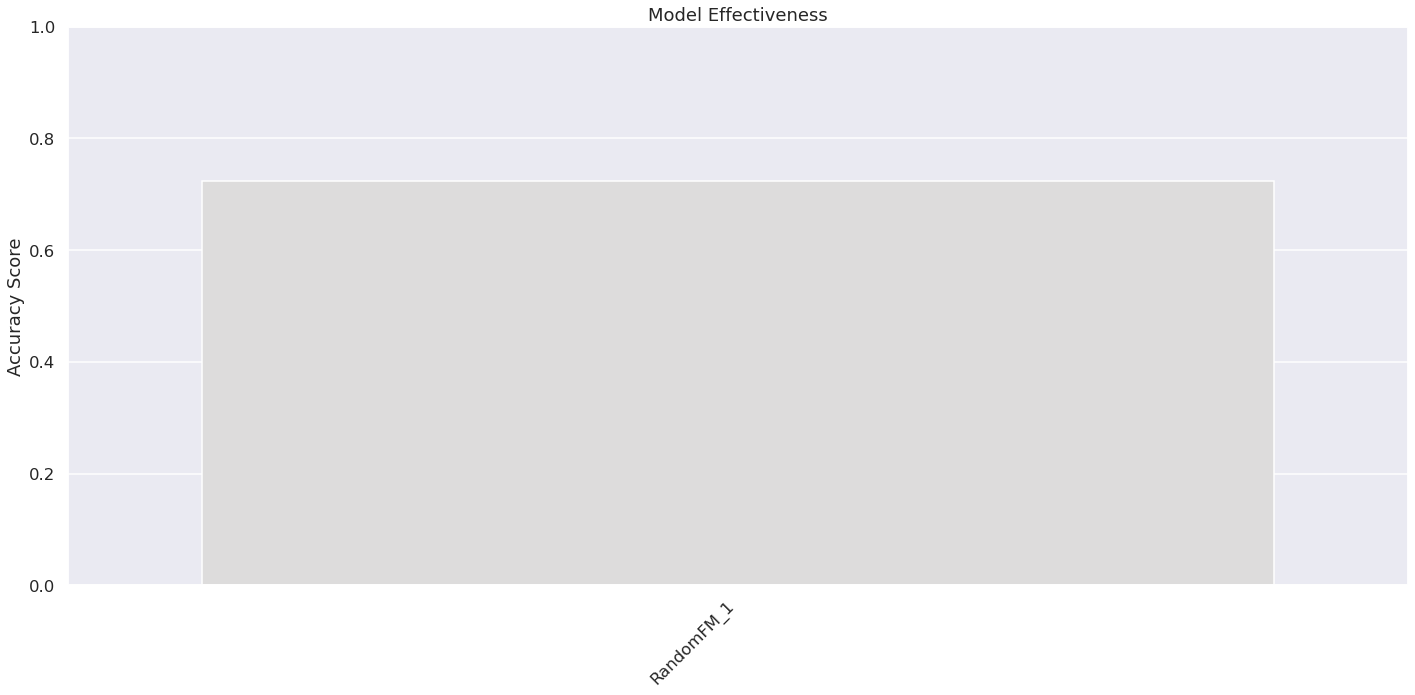

In [16]:
model_run.plot_models()

## Modeler

### Random Forests

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
Train Accuracy :  0.9231
Test Accuracy :  0.7237
------------------------------------------------------------

                         precision    recall  f1-score   support

             functional       0.74      0.83      0.78      8093
functional needs repair       0.57      0.23      0.33      1086
         non functional       0.71      0.66      0.69      5671

               accuracy                           0.72     14850
              macro avg       0.67      0.57      0.60     14850
           weighted avg       0.72      0.72      0.71     14850

------------------------------------------------------------




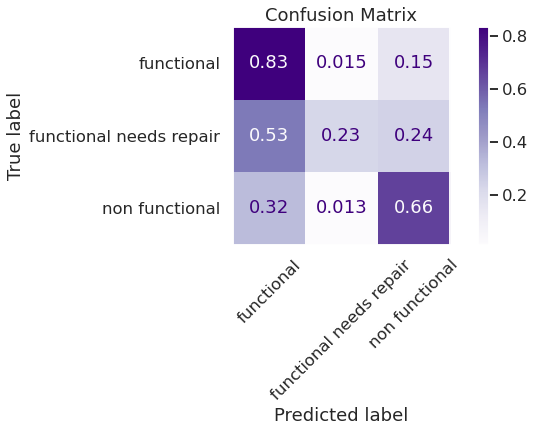

(<Figure size 720x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>)

In [17]:
model_run.model_evaluation('RandomFM_1')

root - INFO - Model RandomFM_1 has permutation importances of construction_year    0.070875
amount_tsh           0.063064
latitude             0.053825
longitude            0.045333
population           0.038061
date_recorded        0.036182
gps_height           0.024337
region_code          0.013192
district_code        0.011374
id                   0.000040
dtype: float64


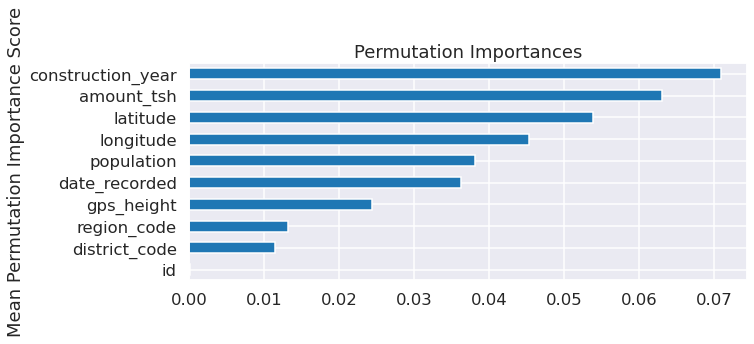

In [18]:
importance_kwargs = dict(n_repeats=10, n_jobs=3)
model_run.permutation_importance('RandomFM_1', perm_kwargs=importance_kwargs)